## 설정

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터셋 다운로드 및 탐색

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```
- 5가지 클래스로 구성 돼 있다.

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir) / "flower_photos"

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### 첫 번째 장미 데이터 시각화

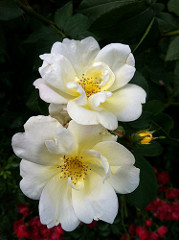

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### 첫 번째 튤립 데이터 시각화

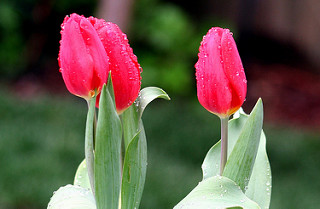

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## 데이터셋 만들기

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


- 이미지의 ``80%`` 는 **훈련**, ``20%`` 는 **검증** 에 사용한다.

### 클래스 명 출력

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화

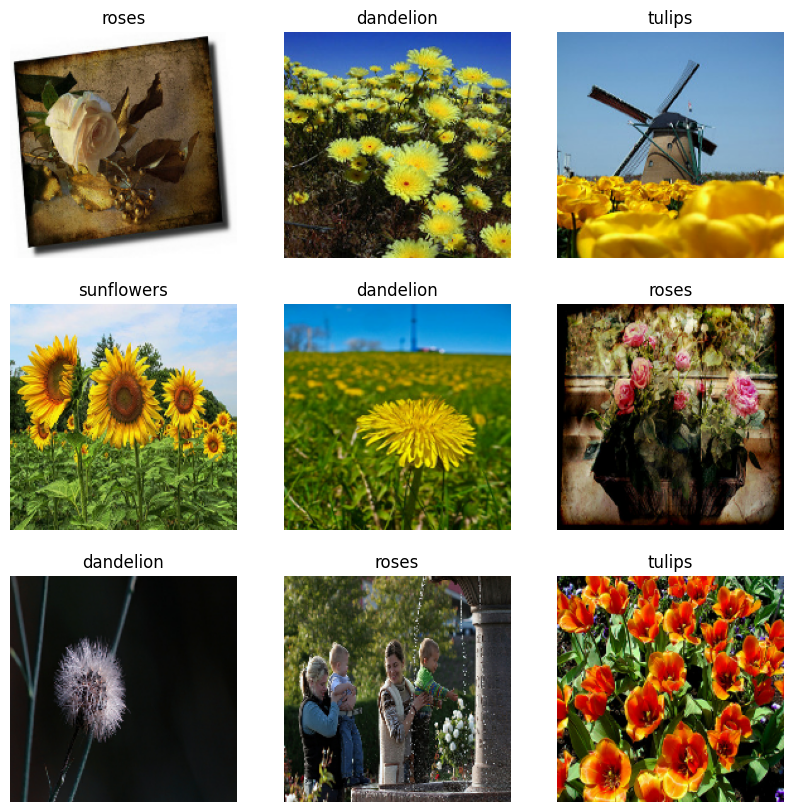

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 성능을 높이도록 데이터셋 구성하기

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 정규화

In [12]:
normalization_layer = layers.Rescaling(1./255)

- ``Dataset.map`` 을 사용해서 이 레이어를 데이터셋에 적용할 수 있다.
- ``normalization_layer`` 가 ``Rescaling``의 **인스턴스**가 되며, ``__call__`` 메소드가 구현돼 있어 **함수** 처럼 사용이 가능하다.

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9991613


- **정규화** 가 됐는지 확인

## 기본 Keras 모델

### 모델 만들기

In [14]:
num_classes = len(class_names)

model = Sequential([
  keras.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 모델 컴파일하기

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 훈련하기

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.3836 - loss: 1.4582 - val_accuracy: 0.5845 - val_loss: 1.0741
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5848 - loss: 1.0232 - val_accuracy: 0.6322 - val_loss: 1.0171
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.6887 - loss: 0.8222 - val_accuracy: 0.6499 - val_loss: 0.8615
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7731 - loss: 0.5989 - val_accuracy: 0.6635 - val_loss: 0.9007
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8678 - loss: 0.3763 - val_accuracy: 0.6267 - val_loss: 1.0847
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9282 - loss: 0.2336 - val_accuracy: 0.6717 - val_loss: 1.0681
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9722 - loss: 0.0925 - val_accuracy: 0.6757 - val_loss: 1.2438
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9898 - loss: 0.0477 - val_accuracy: 0.6594 - v

### 훈련 결과 시각화 및 평가

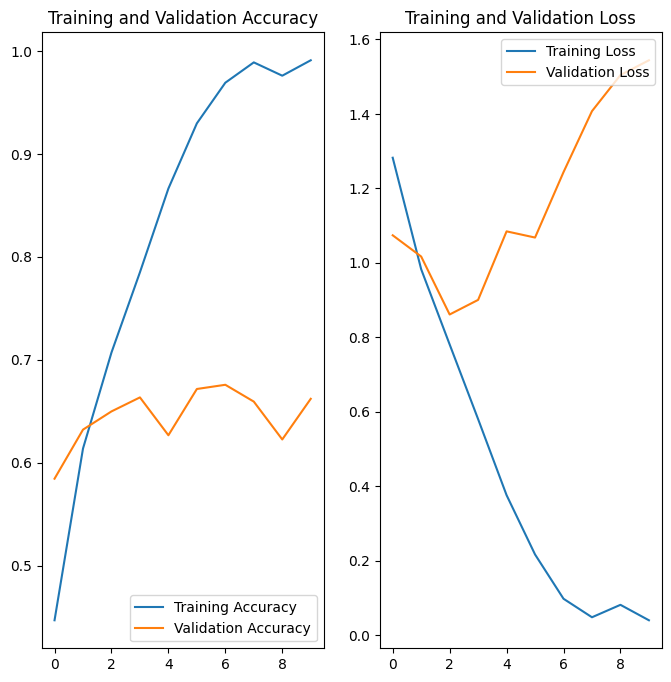

Total Epochs: 10

 최종 - Accuracy: 0.9911, Validation Accuracy: 0.6621
 최종 - Loss: 0.0403, Validation Loss: 1.5442



In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(f"Total Epochs: {len(acc)}\n")
print(f" 최종 - Accuracy: {acc[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")
print(f" 최종 - Loss: {loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}\n")

### 과대적합(과적합)
- **모델** 이 ``훈련 데이터`` 에 대해서는 ``99%``로 거의 완벽하게 맞췄지만, ``검증 데이터`` 에 대해서는 ``66%`` 정도로 성능이 뚝 떨어졌다.
- 이는 **모델** 이 ``훈련 데이터`` 를 **암기하듯 외운 상태** 로 새로운 데이터를 **일반화 하지 못한거다.**
- 이런 ``과대적합(과적합)`` 문제를 해결하기위해 이 챕터에서는 ``데이터 증강`` , ``모델에 드롭아웃을 추가`` 한다.

## 데이터 증강

- **데이터 증강** 이란 **조금씩 다르게 변형** 해서 **새로운 데이터처럼** 만들어내는 방법이다.
- **과대적합(과적합)** 은 일반적으로 훈련 예제가 **적을 때** 발생한다. 그러므로 ``데이터 증강 기법`` 을 이용해서 기존 예제에서 **추가 훈련 데이터를 생성해** 훈련시킨다.

In [19]:
data_augmentation = Sequential(
  [
    keras.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### 데이터 증강 데이터 시각화

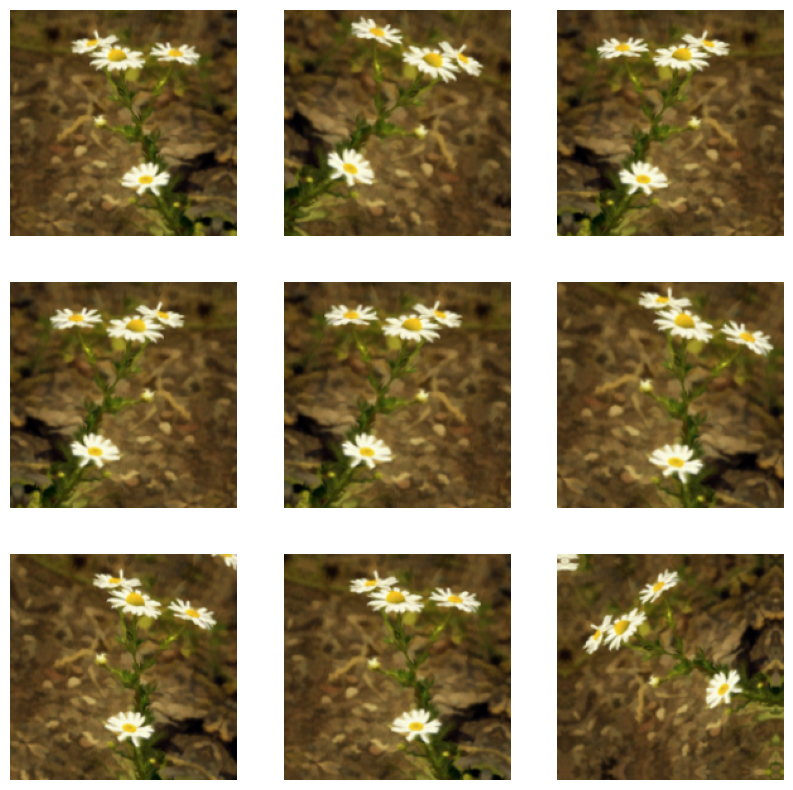

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

- 1개의 이미지로 9번 증강해서, 1개의 이미지로 9개의 이미지를 만든다.
    - ``RandomFlip("horizontal")`` : **``랜덤``으로 좌우 반전**
    - ``RandomRotation(0.1)`` : **약 ``±10%`` 각도로 회전**
    - ``RandomZoom(0.1)`` : **약 ``±10%`` 확대/축소**

## 드롭아웃

- 신경망의 과대적합(과적합)을 방지하기 위한 정규화 기법이다.
- 드롭아웃 레이어는 지정된 확률(rate)만큼 뉴런을 차단한다.
```python
layers.Dropout(0.5) → 50%의 뉴런을 랜덤하게 차단한다.
```

### 모델에 드롭아웃 레이어 추가

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### 모델 컴파일 및 훈련

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8281 - loss: 0.4687 - val_accuracy: 0.7384 - val_loss: 0.6940
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8100 - loss: 0.5040 - val_accuracy: 0.7398 - val_loss: 0.6845
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8341 - loss: 0.4461 - val_accuracy: 0.7289 - val_loss: 0.6968
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8274 - loss: 0.4694 - val_accuracy: 0.7371 - val_loss: 0.7332
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8373 - loss: 0.4343 - val_accuracy: 0.7343 - val_loss: 0.8107
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8522 - loss: 0.3948 - val_accuracy: 0.7507 - val_loss: 0.6714
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8502 - loss: 0.3885 - val_accuracy: 0.7534 - val_loss: 0.7217
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8535 - loss: 0.3955 - val_accuracy: 0.7275 - v

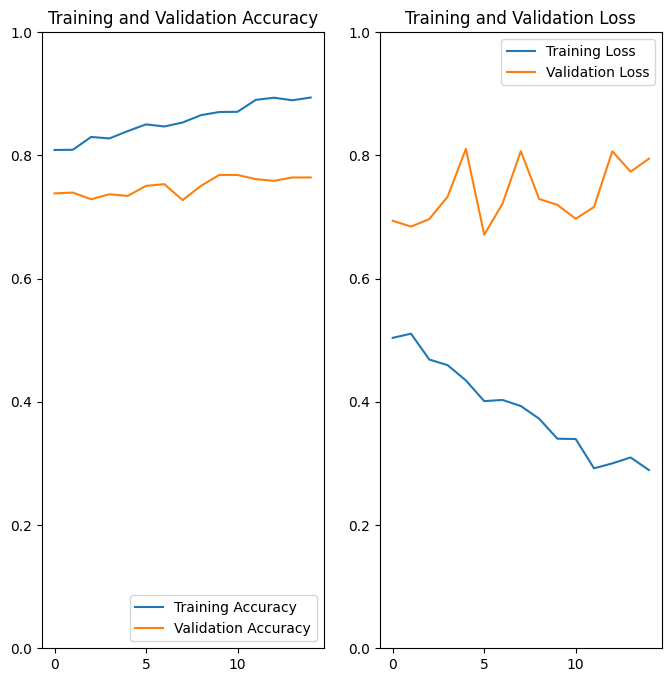

Total Epochs: 15

 최종 - Accuracy: 0.8941, Validation Accuracy: 0.7643
 최종 - Loss: 0.2893, Validation Loss: 0.7948



In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(f"Total Epochs: {len(acc)}\n")
print(f" 최종 - Accuracy: {acc[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")
print(f" 최종 - Loss: {loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}\n")

- ``데이터 증강`` 과  ``드롭아웃`` 을 적용한 결과, ``훈련 정확도``는 ``89.41%``, ``검증 정확도``는 ``76.43%``로 이전보다 **과대적합(과적합)** 수준이 많이 낮아진걸 볼 수 있다.
- 다만, ``Validation_Loss``가 ``0.7948``로 ``검증 데이터`` 에 대한 **확신**은 부족한 상태이다.

## 테스트

In [31]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
This image most likely belongs to sunflowers with a 99.99 percent confidence.


- 테스트 용으로 빨간 해바라기 img 1개를 다운로드 한 뒤, 학습된 모델에 입력하여 어떤 클래스인지 예측해보았다.
- 결과, 모델은 해당 이미지를 ``99.99%`` 로 해바라기 라고 판단하고 있다.